In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import statsmodels.api as sm

# 0. Data

Source: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling

In [5]:
df = pd.read_csv("./churn-data.csv")

In [6]:
sorted(df.columns)

['Age',
 'Balance',
 'CreditScore',
 'CustomerId',
 'EstimatedSalary',
 'Exited',
 'Gender',
 'Geography',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts',
 'RowNumber',
 'Surname',
 'Tenure']

In [7]:
df.shape

(10000, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
df["MultipleProduct"] = df["NumOfProducts"].apply(lambda x: 1 if x > 1 else 0)

In [10]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,MultipleProduct
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.491600
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.499954
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000


# 1. Effect Estimation

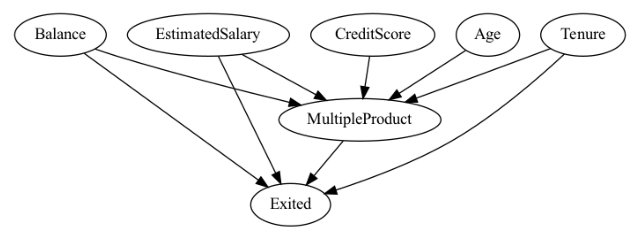

In [28]:
from dowhy import CausalModel
model = CausalModel(
    data=df,
    treatment="MultipleProduct",
    outcome="Exited",
    common_causes=["Balance", "EstimatedSalary", "Tenure"],
    instruments=["Age", "CreditScore"]
)
model.view_model()

In [12]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                   
──────────────────(E[Exited|Tenure,Balance,EstimatedSalary])
d[MultipleProduct]                                          
Estimand assumption 1, Unconfoundedness: If U→{MultipleProduct} and U→Exited then P(Exited|MultipleProduct,Tenure,Balance,EstimatedSalary,U) = P(Exited|MultipleProduct,Tenure,Balance,EstimatedSalary)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                    -1⎤
 ⎢         d                  ⎛         d                            ⎞  ⎥
E⎢───────────────────(Exited)⋅⎜───────────────────([MultipleProduct])⎟  ⎥
 ⎣d[CreditScore  Age]         ⎝d[CreditScore  Age]                   ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Exited then ¬(U →→{CreditScore,Age})
Estimand assumption 2, Exclusion: If we remove {CreditScore,Age}→{MultipleP

In [13]:
#Causal Effect Estimation
estimate = model.estimate_effect(
    estimands,
    method_name = "backdoor.propensity_score_weighting"
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                   
──────────────────(E[Exited|Tenure,Balance,EstimatedSalary])
d[MultipleProduct]                                          
Estimand assumption 1, Unconfoundedness: If U→{MultipleProduct} and U→Exited then P(Exited|MultipleProduct,Tenure,Balance,EstimatedSalary,U) = P(Exited|MultipleProduct,Tenure,Balance,EstimatedSalary)

## Realized estimand
b: Exited~MultipleProduct+Tenure+Balance+EstimatedSalary
Target units: ate

## Estimate
Mean value: -0.13904650583124545



In [14]:
refute_results = model.refute_estimate(
    estimands,
    estimate,
    "random_common_cause"
)
print(refute_results)

Refute: Add a random common cause
Estimated effect:-0.13904650583124545
New effect:-0.13904650583124542
p value:1.0



In [15]:
refute_results = model.refute_estimate(
    estimands,
    estimate,
    "data_subset_refuter"
)
print(refute_results)

Refute: Use a subset of data
Estimated effect:-0.13904650583124545
New effect:-0.13842175180225635
p value:0.8200000000000001



In [16]:
refute_results = model.refute_estimate(
    estimands,
    estimate,
    "placebo_treatment_refuter"
)
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.13904650583124545
New effect:0.02486926352643408
p value:0.0



# 2. Graphical Causal Model

In [17]:
import networkx as nx

causal_graph = nx.DiGraph([
    ('CreditScore', 'MultipleProduct'),
    ('Age', 'MultipleProduct'),
    ('MultipleProduct', 'Exited'),
    ('Balance', 'MultipleProduct'),
    ('EstimatedSalary', 'MultipleProduct'),
    ('Tenure', 'MultipleProduct'),
    ('Balance', 'Exited'),
    ('EstimatedSalary', 'Exited'),
    ('Tenure', 'Exited'),
])

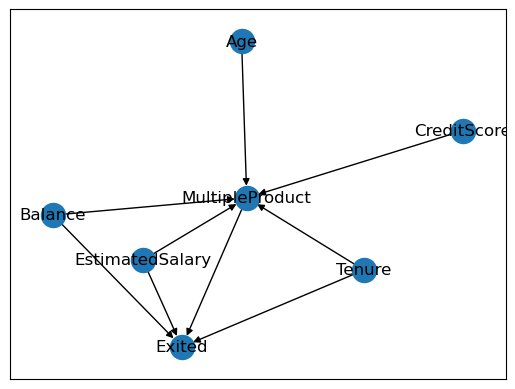

In [49]:
nx.draw_networkx(causal_graph, arrows=True)

In [18]:
from dowhy import gcm

# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, df)

In [19]:
gcm.fit(scm, df)

Fitting causal mechanism of node Tenure: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 153.26it/s]


In [20]:
arrow_strengths = gcm.arrow_strength(scm, target_node='Exited')
arrow_strengths

{('Balance', 'Exited'): 0.004409170886075944,
 ('EstimatedSalary', 'Exited'): 0.0015105635135135094,
 ('MultipleProduct', 'Exited'): 0.008995459302325575,
 ('Tenure', 'Exited'): 0.004945875000000006}

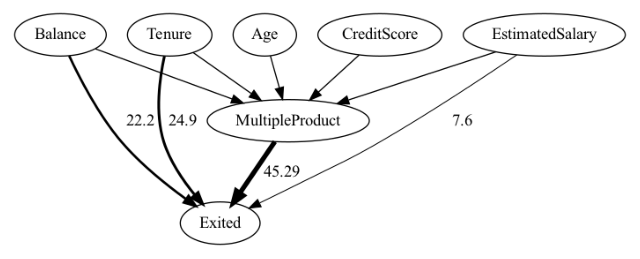

In [21]:
total = sum(arrow_strengths.values())
arrow_strengths_perc = {key: val/total*100 for key, val in arrow_strengths.items()}

gcm.util.plot(
    causal_graph,
    causal_strengths=arrow_strengths_perc,
    figure_size=[8, 5]
)

In [22]:
influence = gcm.intrinsic_causal_influence(scm, target_node='Exited', num_samples_randomization=100)

Estimating Shapley Values. Average change of Shapley values in run 34 (170 evaluated permutations): 1.4471043689666405%: 100%|█| 1/1 [00:12


In [23]:
total = sum([val for key, val in influence.items() if key != "Exited"])
influence_perc = {key: val/total*100 for key, val in influence.items() if key != "Exited"}
influence_perc

{'CreditScore': -0.1491955835011611,
 'Age': -0.11109031021081443,
 'Balance': 26.522259241324463,
 'EstimatedSalary': 14.14289785088865,
 'Tenure': 14.444559591394759,
 'MultipleProduct': 45.15056921010411}

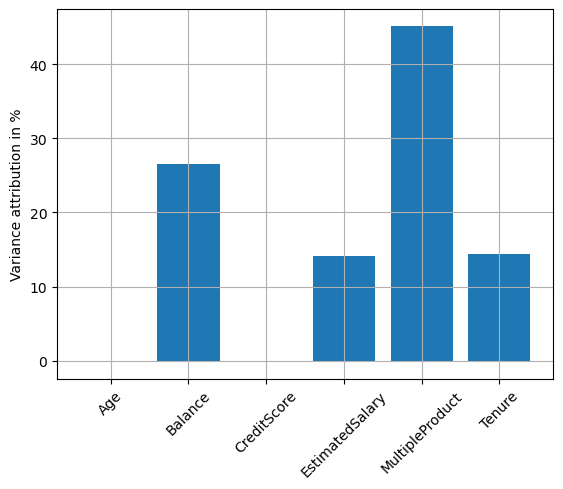

In [24]:
xlabels = sorted(influence_perc.keys())
yvals = [influence_perc[x] for x in xlabels]
plt.bar(xlabels, yvals)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Variance attribution in %")
plt.show()

In [63]:
attributions = gcm.attribute_anomalies(
    scm, 
    target_node='Exited', 
    anomaly_samples=df.loc[df["Exited"] == 1].iloc[1:2]
)

Estimating Shapley Values. Average change of Shapley values in run 21 (105 evaluated permutations): 2.6072448520034874%: 100%|█| 1/1 [00:0


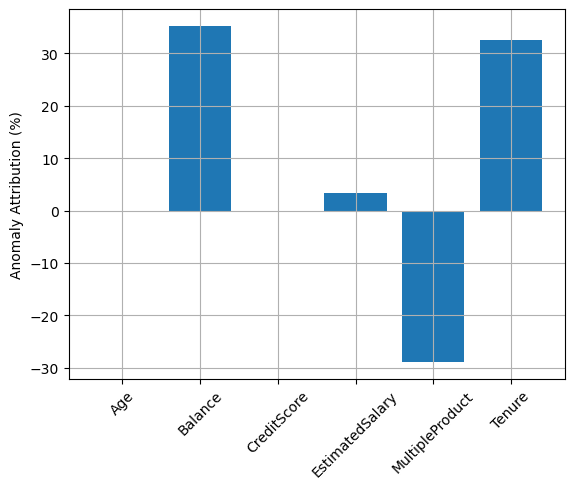

In [64]:
total = sum([abs(val[0]) for key, val in attributions.items() if key != "Exited"])
attributions_perc = {key: val[0]/total*100 for key, val in attributions.items() if key != "Exited"}

xlabels = sorted(attributions_perc.keys())
yvals = [attributions_perc[x] for x in xlabels]
plt.bar(xlabels, yvals)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Anomaly Attribution (%)")
plt.show()

In [65]:
df.loc[df["Exited"] == 1].iloc[1][list(attributions_perc.keys())]

CreditScore              502
Age                       42
Balance             159660.8
EstimatedSalary    113931.57
Tenure                     8
MultipleProduct            1
Name: 2, dtype: object